In [1]:
import tensorflow as tf
from tensorflow .keras import models,layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

2024-04-04 12:44:36.977160: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-04 12:44:36.977286: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-04 12:44:37.116241: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/potato-disease-dataset/Potato_Disease_Dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE  
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names

In [5]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
len(dataset)

68

In [7]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1]


In [8]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[149. 141. 154.]
  [150. 142. 155.]
  [151. 143. 156.]
  ...
  [157. 149. 160.]
  [153. 145. 156.]
  [148. 140. 151.]]

 [[146. 138. 151.]
  [148. 140. 153.]
  [150. 142. 155.]
  ...
  [157. 149. 160.]
  [153. 145. 156.]
  [149. 141. 152.]]

 [[144. 136. 149.]
  [146. 138. 151.]
  [148. 140. 153.]
  ...
  [156. 148. 159.]
  [152. 144. 155.]
  [149. 141. 152.]]

 ...

 [[107.  99. 114.]
  [113. 105. 120.]
  [114. 106. 121.]
  ...
  [119. 111. 124.]
  [119. 111. 124.]
  [120. 112. 125.]]

 [[109. 101. 116.]
  [115. 107. 122.]
  [116. 108. 123.]
  ...
  [117. 109. 122.]
  [118. 110. 123.]
  [119. 111. 124.]]

 [[102.  94. 109.]
  [107.  99. 114.]
  [109. 101. 116.]
  ...
  [116. 108. 121.]
  [116. 108. 121.]
  [118. 110. 123.]]]


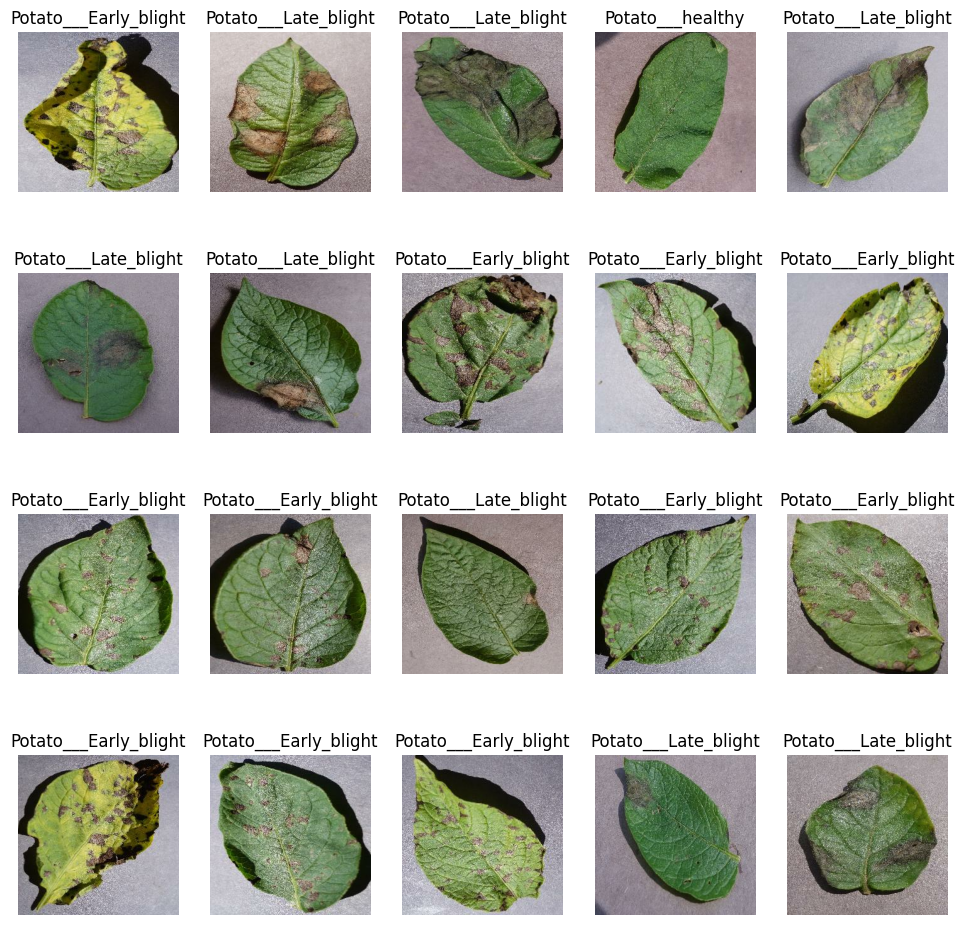

In [9]:
plt.figure(figsize=(12,12))
for image_batch,label_batch in dataset.take(1):
    for i in range(20):
        ax=plt.subplot(4,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

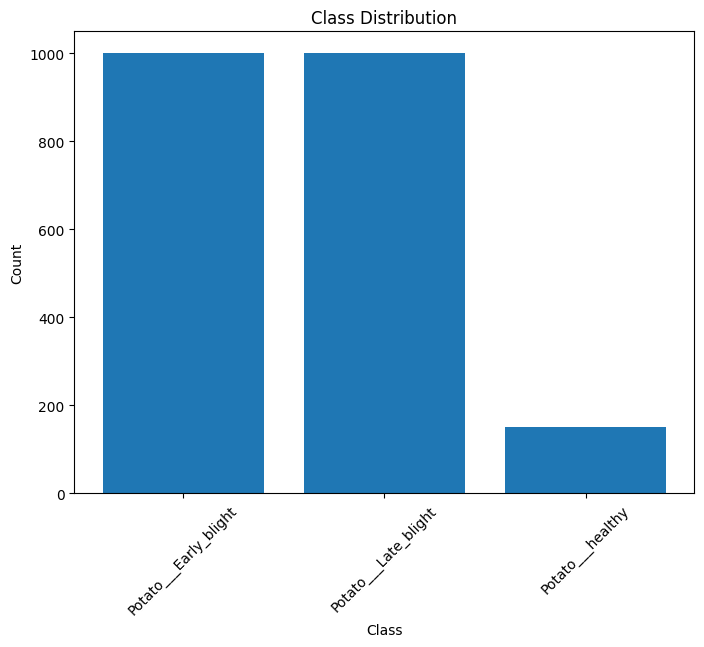

In [10]:
#It willl perform class distribution
plt.figure(figsize=(8, 6))
class_counts = [0] * len(class_names)
for _, labels in dataset:
    for label in labels.numpy():
        class_counts[label] += 1
plt.bar(class_names, class_counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [11]:
# Compute and visualize mean and standard deviation of pixel values
mean_pixels = []
std_pixels = []
for images, _ in dataset:
    mean_pixels.append(tf.math.reduce_mean(images, axis=[0, 1, 2]))
    std_pixels.append(tf.math.reduce_std(images, axis=[0, 1, 2]))

mean_pixels = tf.math.reduce_mean(mean_pixels, axis=0)
std_pixels = tf.math.reduce_mean(std_pixels, axis=0)
print("Mean pixel values:", mean_pixels.numpy())
print("Standard deviation of pixel values:", std_pixels.numpy())


Mean pixel values: [125.92111 130.3813  108.8324 ]
Standard deviation of pixel values: [48.821854 45.241886 54.632122]


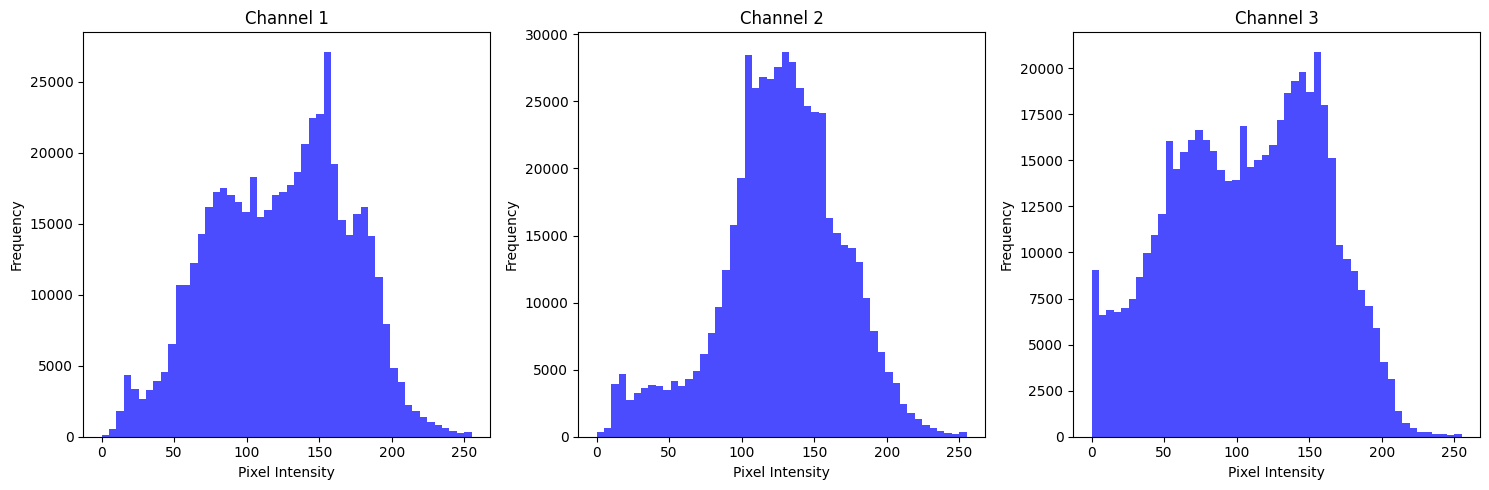

In [12]:
# Plot histogram of pixel intensities for each channel
plt.figure(figsize=(15, 5))
for i in range(CHANNELS):
    plt.subplot(1, CHANNELS, i + 1)
    plt.hist(images[:, :, :, i].numpy().flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Channel {i+1}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [13]:
#Split dataset into train_ds,val_ds,test_ds.
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=121)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [14]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(val_ds)

6

In [17]:
len(test_ds)

8

In [18]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [23]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [24]:
resize_and_rescale

<Sequential name=sequential, built=False>

In [25]:

data_augmentation

<Sequential name=sequential_1, built=False>

In [26]:
IMAGE_SIZE

256

In [27]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

In [28]:
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [29]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [31]:
history=model.fit(train_ds,batch_size=BATCH_SIZE,validation_data=val_ds,verbose=1,epochs=EPOCHS)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 89ms/step - accuracy: 0.4757 - loss: 0.9223 - val_accuracy: 0.5052 - val_loss: 0.9612
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.6900 - loss: 0.6901 - val_accuracy: 0.8125 - val_loss: 0.4150
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8615 - loss: 0.3413 - val_accuracy: 0.8906 - val_loss: 0.2919
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.8952 - loss: 0.2780 - val_accuracy: 0.9115 - val_loss: 0.2634
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9043 - loss: 0.2285 - val_accuracy: 0.8854 - val_loss: 0.2209
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.8893 - loss: 0.2735 - val_accuracy: 0.9219 - val_loss: 0.2132
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9142 - loss: 0.2028 - val_accuracy: 0.8750 - val_loss: 0.2980
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9242 - loss: 0.1903 - val_accuracy: 0.9219 - 

In [32]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.9866 - loss: 0.0222


In [33]:
scores

[0.01745053194463253, 0.9921875]

In [34]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [35]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [36]:
history.history['loss']

[0.8600732088088989,
 0.5604345798492432,
 0.32971951365470886,
 0.28682658076286316,
 0.22817260026931763,
 0.2651379406452179,
 0.22898973524570465,
 0.1883823424577713,
 0.13881815969944,
 0.12356597185134888,
 0.10659156739711761,
 0.09671168774366379,
 0.0788530483841896,
 0.08619799464941025,
 0.07227947562932968,
 0.06148751080036163,
 0.06371515989303589,
 0.06497203558683395,
 0.04838979244232178,
 0.0565003864467144,
 0.05912327021360397,
 0.05305202305316925,
 0.07189104706048965,
 0.03594176843762398,
 0.05320203676819801,
 0.040443055331707,
 0.026835378259420395,
 0.040633756667375565,
 0.08456648886203766,
 0.04039698466658592,
 0.05616467073559761,
 0.06555701047182083,
 0.0462169349193573,
 0.03413651883602142,
 0.026490984484553337,
 0.027448570355772972,
 0.013024624437093735,
 0.03905648738145828,
 0.036345649510622025,
 0.032999373972415924,
 0.032472915947437286,
 0.03206780552864075,
 0.04625251144170761,
 0.029356015846133232,
 0.05075767636299133,
 0.0660646632

In [37]:
history.history['accuracy']

[0.5381455421447754,
 0.7517605423927307,
 0.8656103014945984,
 0.8884976506233215,
 0.9031690359115601,
 0.8926056623458862,
 0.9061033129692078,
 0.9260563254356384,
 0.9460093975067139,
 0.954812228679657,
 0.9577465057373047,
 0.9612675905227661,
 0.9730046987533569,
 0.9730046987533569,
 0.9741784334182739,
 0.9776995182037354,
 0.9800469279289246,
 0.9735915660858154,
 0.9794601202011108,
 0.9800469279289246,
 0.9782863855361938,
 0.9835680723190308,
 0.9700704216957092,
 0.987089216709137,
 0.9812206625938416,
 0.9888497591018677,
 0.9917840361595154,
 0.9865023493766785,
 0.9741784334182739,
 0.9882628917694092,
 0.9794601202011108,
 0.9724178314208984,
 0.9876760840415955,
 0.9865023493766785,
 0.9911971688270569,
 0.9911971688270569,
 0.9947183132171631,
 0.9900234937667847,
 0.98591548204422,
 0.9911971688270569,
 0.9847418069839478,
 0.9888497591018677,
 0.9847418069839478,
 0.9906103014945984,
 0.9835680723190308,
 0.9759389758110046,
 0.9712441563606262,
 0.98826289176940

In [38]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


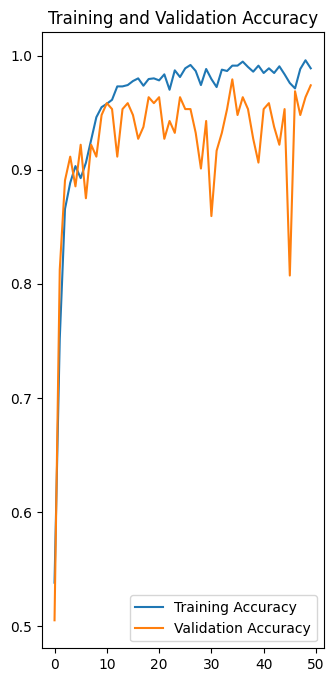

In [39]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),accuracy,label='Training Accuracy')
plt.plot(range(EPOCHS),val_accuracy,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
plt.show()

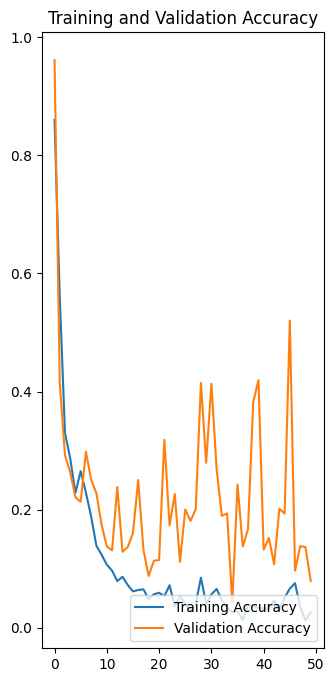

In [40]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training Accuracy')
plt.plot(range(EPOCHS),val_loss,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
plt.show()

First Image to predict
Actual Label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted Label: Potato___Late_blight


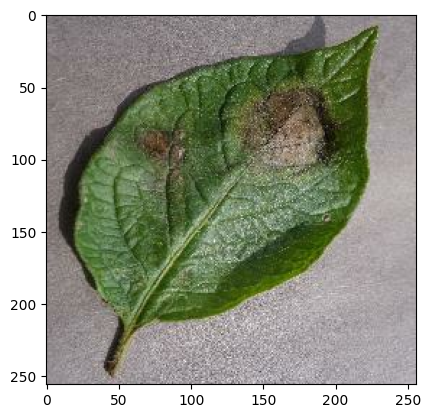

In [77]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    print("First Image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])
    
    batch_prediction=model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [46]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


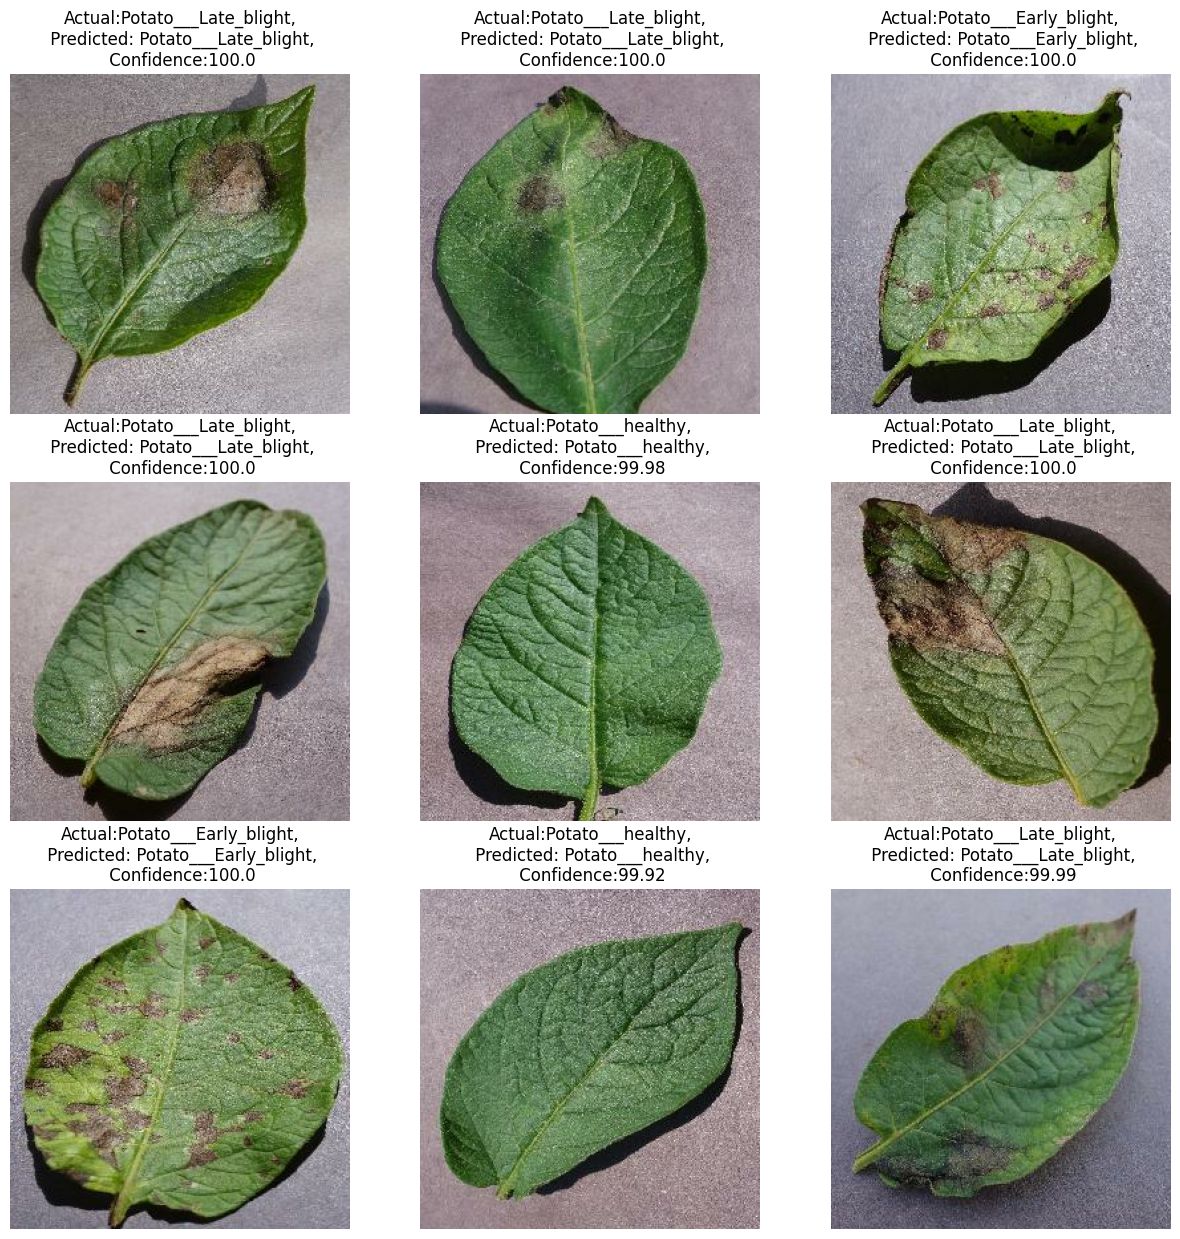

In [43]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        
        actual_class =class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class},\n Confidence:{confidence}")
        plt.axis("off")